# Fitting a line to data - a full tutorial

_Boris Leistedt, August 2017_

This notebook is available at [this location on Github](https://github.com/ixkael/Prob-tools/blob/master/notebooks/Fitting%20a%20line%20to%20data%20-%20a%20full%20tutorial.ipynb).

Road map:
- fitting a line to data: graphical models
- maximum-likelihood approach
- application of Bayes' theorem
- parameter inference with gridding
- parameter inference with MCMC
- more parameters: fitting a line with both x and y uncertainties
- analytic marginalization of latent variables
- high-dimensional parameter inference with HMC
- numerical marginalization of latent variables
- mixture models: fitting multiple lines to data
- nested sampling 


This notebook It assumes some basic knowledge about Bayesian inference and data analysis. It is accompanied with a set of slides.

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

from IPython.display import HTML

This is a tutorial.

Don't be like

In [2]:
HTML('<img src="./pics/monkey.gif" width=600>')

Play with the code! Try and do the exercises.

Please interrupt me if you are lost or if you disagree with what I say.

All questions are welcome, especially the ones that you find "simple" (they are often very good, and not simple!)

If you haven't done it, install those packages using conda and/or pip:

``conda install numpy scipy pandas matplotlib jupyter pip``

``pip install emcee corner``

start a jupyter kernel: ``jupyter notebook``

and open a copy of this notebook.

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
matplotlib.rc("font", family="serif", size=14)
matplotlib.rc("figure", figsize="10, 5")
colors = ['k', 'c', 'm', 'y']
matplotlib.rc('axes', prop_cycle=cycler("color", colors))

import scipy.optimize
import numpy as np
import daft

# Why Bayesian inference?

Constrain model parameters with data.

In [4]:
HTML('<img src="./pics/data.jpg" width=500>')

# Fitting aline to data: basic setup

Our model will consist of a set of $N$ i.i.d. observations, including: a coordinate (fixed parameter) $x_i$, a noise level  $\sigma_i$, and observed variable $\hat{y}_i$ drawn from a Gaussian with mean $mx_i + b$ and variance $\sigma^2_i$, i.e. $\hat{y}_i \sim \mathcal{N}(mx_i+b;\sigma_i^2)$.

Let's generate a model:

In [5]:
slope_true = np.random.uniform(0, 1)
intercept_true = np.random.uniform(0, 1)
print('Slopes:', slope_true)
print('Intercepts:', intercept_true)
# This notebook is ready for you to play with 2+ components and more complicated models.

Slopes: 0.7470973979706044
Intercepts: 0.7238952467584417


Let's generate some data drawn from that model:

In [6]:
ndatapoints = 20
xis_true = np.random.uniform(0, 1, ndatapoints)
x_grid = np.linspace(0, 1, 100)


def model_linear(xs, slope, intercept): return xs * slope + intercept
yis_true = model_linear(xis_true, slope_true, intercept_true)

In [7]:
sigma_yis = np.repeat(0.1, ndatapoints) * np.random.uniform(0.5, 2.0, ndatapoints)
yis_noisy = yis_true + np.random.randn(ndatapoints) * sigma_yis

In [8]:
y_min, y_max = np.min(yis_noisy - sigma_yis), np.max(yis_noisy + sigma_yis)
y_min = np.min([y_min, np.min(model_linear(x_grid, slope_true, intercept_true))])
y_max = np.max([y_max, np.max(model_linear(x_grid, slope_true, intercept_true))])

(0.41604768379354951, 1.7139330794192902)

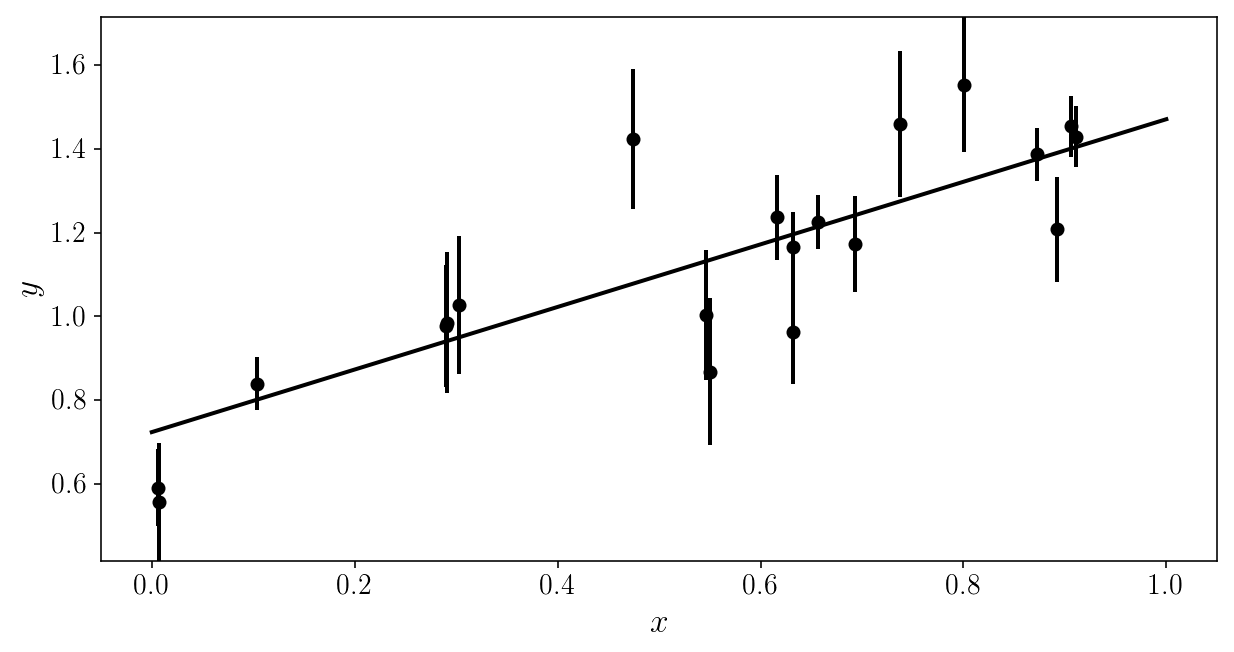

In [9]:
plt.plot(x_grid, model_linear(x_grid, slope_true, intercept_true), c=colors[0])
plt.errorbar(xis_true, yis_noisy, sigma_yis, fmt='o', c=colors[0])
plt.xlabel('$x$'); plt.ylabel('$y$'); plt.ylim([y_min, y_max])

We are going to pretend we don't know the true model. 

Forget what you saw (please).

Here is the noisy data to be analyzed. Can you (mentally) fit a line through it?

(0.41604768379354951, 1.7139330794192902)

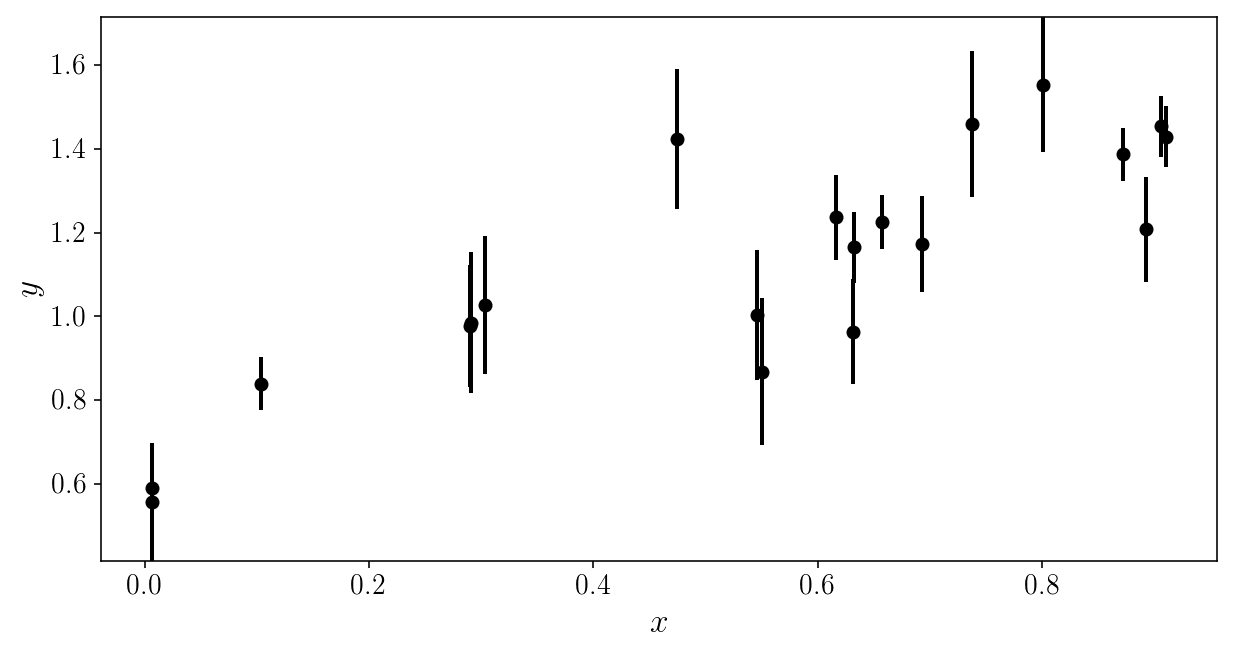

In [10]:
plt.errorbar(xis_true, yis_noisy, sigma_yis, fmt='o')
plt.xlabel('$x$'); plt.ylabel('$y$'); plt.ylim([y_min, y_max])

Let's define a loss/cost function: the total weighted squared error, also called chi-squared: 
$$ \chi^2 = \sum_i \left( \frac{ \hat{y}_i - y_i^\mathrm{mod}(x_i, s, m) }{\sigma_i} \right)^2 $$

In [11]:
def loss(observed_yis, yi_uncertainties, model_yis):
    scaled_differences = (observed_yis - model_yis) / yi_uncertainties
    return np.sum(scaled_differences**2, axis=0)

We want to minimize this chi-squared to obtain the best possible fit to the data. 

Let us look at the fit for a couple of (random) sets of parameters.

In [12]:
random_slopes = np.array([0.25, 0.25, 0.75, 0.75])
random_intercepts = np.array([0.25, 0.75, 0.25, 0.75])

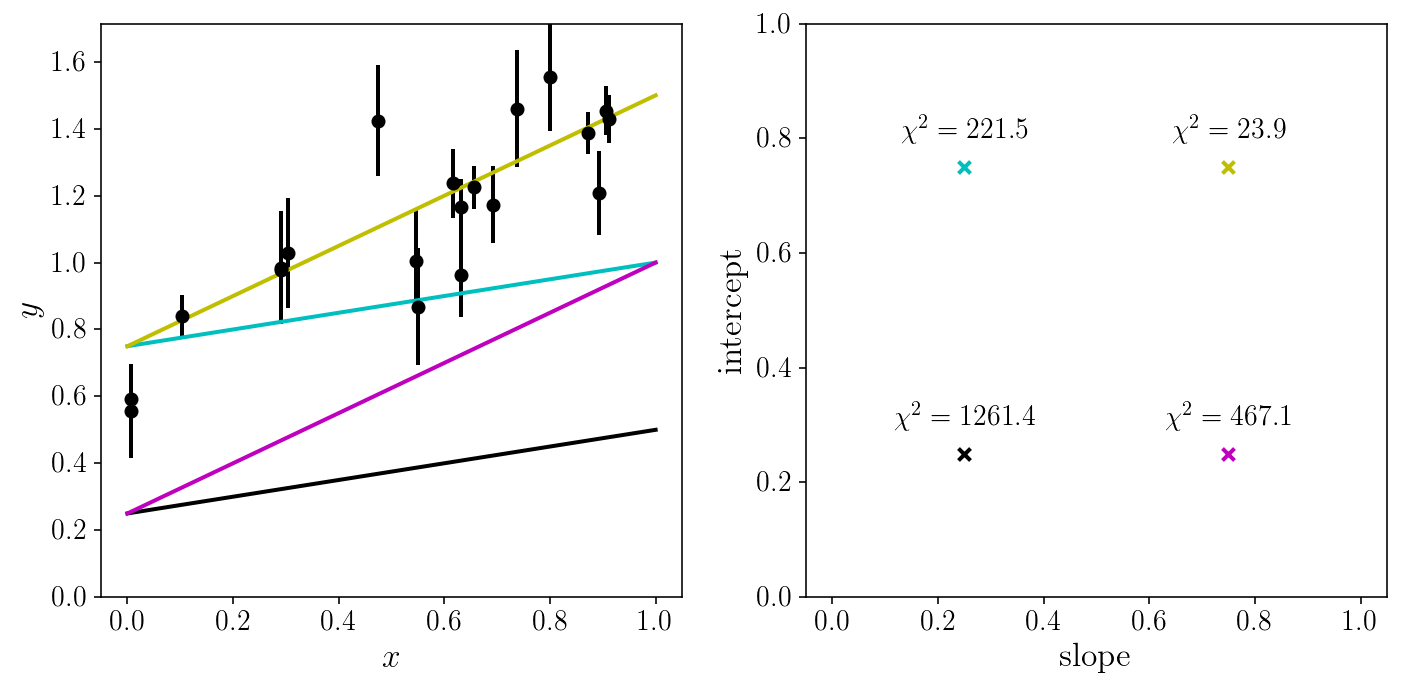

In [13]:
fig, axs = plt.subplots(1, 2, sharex=True)
axs[0].errorbar(xis_true, yis_noisy, sigma_yis, fmt='o')
for i, (slope, intercept) in enumerate(zip(random_slopes, random_intercepts)):
    axs[0].plot(x_grid, model_linear(x_grid, slope, intercept), c=colors[i])
    axs[1].scatter(slope, intercept,marker='x', c=colors[i])
    chi2 = loss(yis_noisy[:, None], sigma_yis[:, None], 
                 model_linear(xis_true[:, None], slope, intercept))
    axs[1].text(slope, intercept+0.05, '$\chi^2 = %.1f$'% chi2, 
                horizontalalignment='center')
axs[0].set_xlabel('$x$'); axs[0].set_ylabel('$y$')
axs[0].set_ylim([0, y_max]); axs[1].set_ylim([0, 1]); 
axs[1].set_xlabel('slope'); axs[1].set_ylabel('intercept')
fig.tight_layout()

Let us try a brute-force search, and grid our 2D parameter space.

EXERCISE

Create a 100 x 100 grid covering our parameter space. 

Evaluate the loss function on the grid, and plot exp(-0.5*loss).

Also find the point that has the minimal loss value.

In [14]:
# SOLUTION
slope_grid, intercept_grid = np.meshgrid(np.linspace(0, 1, 100), 
                                         np.linspace(0, 1, 100))
#np.mgrid[0:1:100j, 0:1:100j]
model_yis = model_linear(xis_true[:, None], 
                         slope_grid.ravel()[None, :], 
                         intercept_grid.ravel()[None, :])
loss_grid = loss(yis_noisy[:, None], sigma_yis[:, None], model_yis[:, :])
# Let's also find the grid point with minimum chi2: 
ml_position = np.argmin(loss_grid)
slope_ml = slope_grid.ravel()[ml_position]
intercept_ml = intercept_grid.ravel()[ml_position]
loss_grid = loss_grid.reshape(slope_grid.shape)

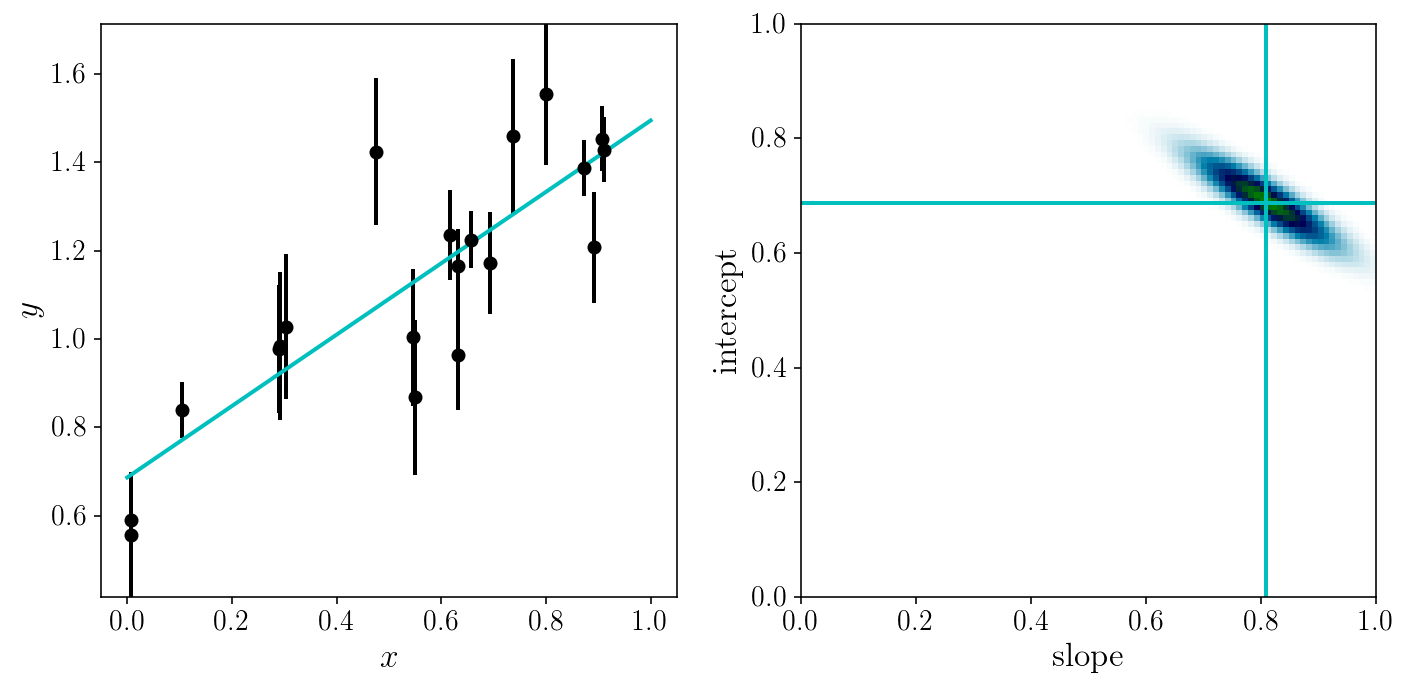

In [15]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False)
axs[0].errorbar(xis_true, yis_noisy, sigma_yis, fmt='o')
axs[0].plot(x_grid, model_linear(x_grid, slope_ml, intercept_ml))
axs[0].set_xlabel('$x$'); axs[0].set_ylabel('$y$')
axs[0].set_ylim([y_min, y_max])
axs[1].set_xlabel('slope'); axs[1].set_ylabel('intercept')
axs[1].axvline(slope_ml, c=colors[1]); axs[1].axhline(intercept_ml, c=colors[1])
axs[1].pcolormesh(slope_grid, intercept_grid, np.exp(-0.5*loss_grid), cmap='ocean_r')
fig.tight_layout()

Why visualize $exp(-\frac{1}{2}\chi^2)$ and not simply the $\chi^2$?

Because the former is proportional to our likelihood:

$$\begin{align}
p(D| P, M) &= p(\{ \hat{y}_i \} \vert \{\sigma_i, x_i\}, \textrm{intercept}, \textrm{slope}) \\
&= \prod_{i=1}^{N} p(\hat{y}_i \vert x_i, \sigma_i, b, m)\\
&= \prod_{i=1}^{N} \mathcal{N}\left(\hat{y}_i - y^\mathrm{mod}(x_i; m, b); \sigma^2_i \right)
\ = \prod_{i=1}^{N} \mathcal{N}\left(\hat{y}_i - m x_i - b; \sigma^2_i \right) \\
&= \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi}\sigma_i}\exp\left( - \frac{1}{2} \frac{(\hat{y}_i - m x_i - b)^2}{\sigma^2_i} \right)  \\
&\propto \ \exp\left( - \sum_{i=1}^{N} \frac{1}{2} \frac{(\hat{y}_i - m x_i - b)^2}{\sigma^2_i} \right) \ = \ \exp\left(-\frac{1}{2}\chi^2\right)
\end{align}
$$

Since the data points are independent and the noise is Gaussian.

Let's visualize the $\chi^2$ for individual objects

In [16]:
model_yis = model_linear(xis_true, slope_ml, intercept_ml)
object_chi2s = 0.5*((yis_noisy - model_yis) / sigma_yis)**2

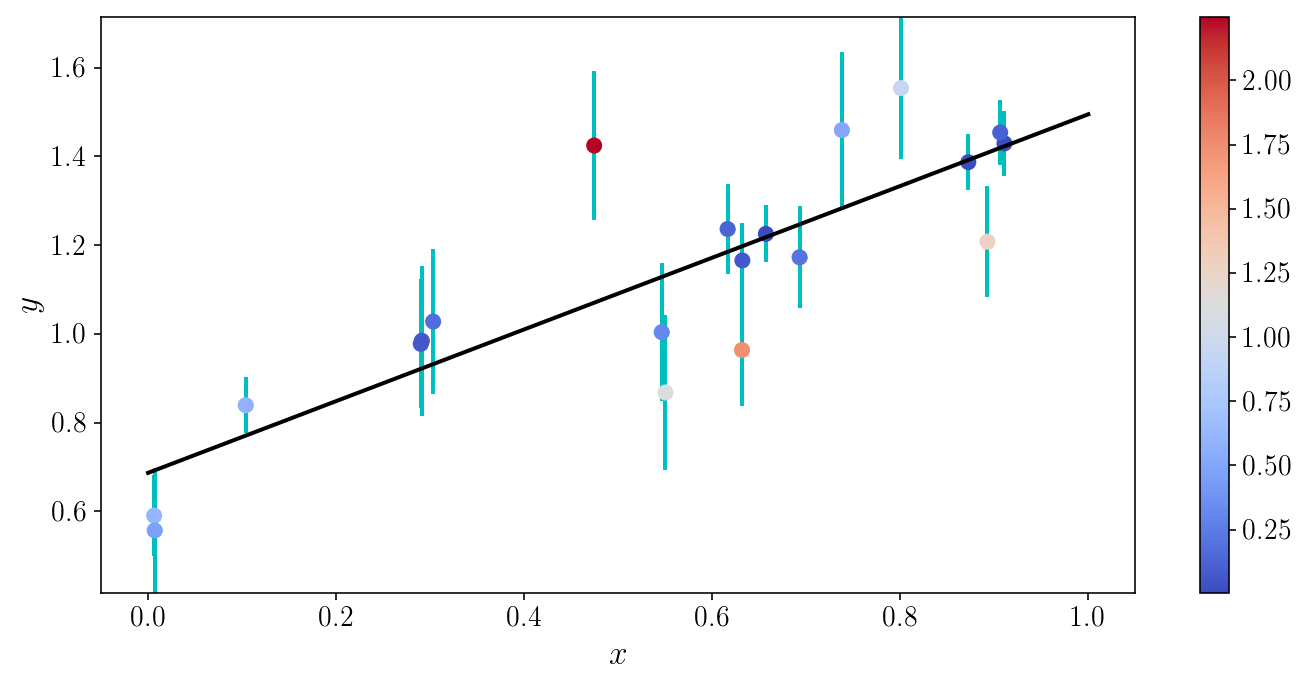

In [17]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_grid, model_linear(x_grid, slope_ml, intercept_ml))
v = ax.scatter(xis_true, yis_noisy, c=object_chi2s, cmap='coolwarm', zorder=0)
ax.errorbar(xis_true, yis_noisy, sigma_yis, fmt='o', zorder=-1)
ax.set_xlabel('$x$'); ax.set_ylabel('$y$'); ax.set_ylim([y_min, y_max])
plt.colorbar(v); fig.tight_layout()

## Digression: the limits of maximum likelihood

Is a line a good model? 

Should we aiming at maximizing the likelihood only?

Here is a danger of Maximum Likelihood: there is always of model that perfectly fits all of the data.
    
This model does not have to be complicated...

EXERCISE (5 min): can you try to write a very flexible model that fits the data perfectly, i.e. go through every single point? What $\chi^2$ does it lead to? 

NOTE: this might not be trivial, so just look for a model that goes through *most* of the data points.

HINT: numpy has good infrastructure for constructing and fitting polynomials... (try `?np.polyfit`).

If you pick a more complicated model you might need to use `scipy.optimize.minimize`. 

In [18]:
# SOLUTION
degree = 150
bestfit_polynomial_coefs = np.polyfit(xis_true, yis_noisy, degree)
bestfit_polynomial = np.poly1d(bestfit_polynomial_coefs)
chi2 = loss(yis_noisy, sigma_yis, bestfit_polynomial(xis_true))
print('The chi2 is', chi2)

The chi2 is 9.26716131458e-08


/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RankWarning: Polyfit may be poorly conditioned
  app.launch_new_instance()


(0.41604768379354951, 1.7139330794192902)

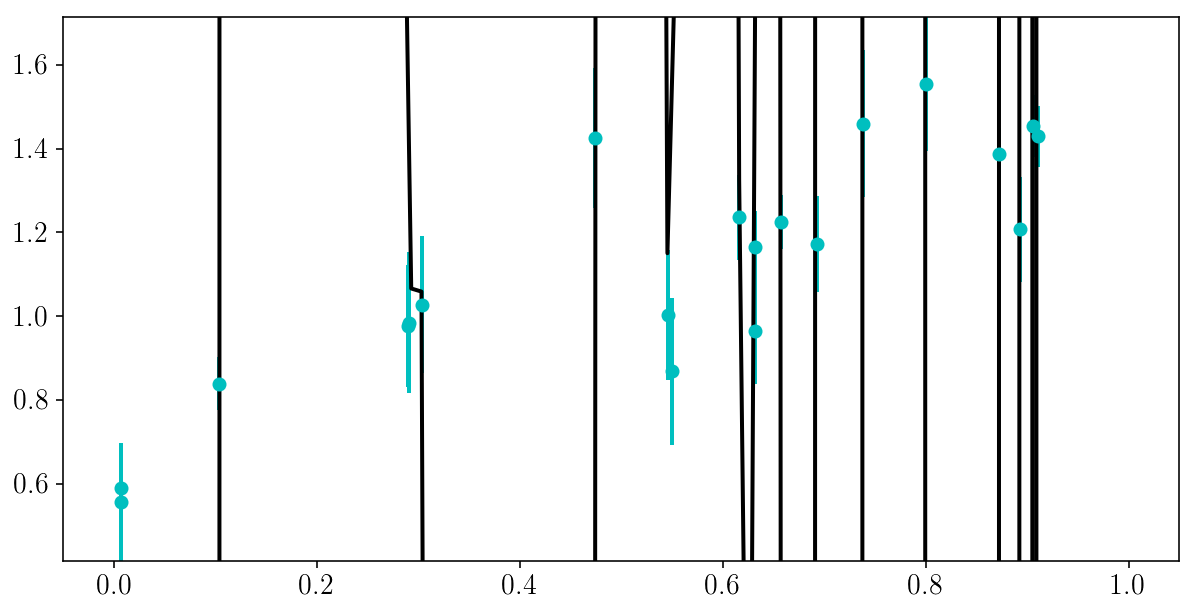

In [19]:
plt.plot(x_grid, bestfit_polynomial(x_grid))
plt.errorbar(xis_true, yis_noisy, sigma_yis, fmt='o')
plt.ylim([y_min, y_max])

In [20]:
HTML('<img src="./pics/hoggmograph.gif" width=500>')
# Copyright Daniela Huppenkothen, Astrohackweek 2015 in NYC

##  Bayes' theorem 
with explicit Model and Fixed parameters conditioned on:

$$p(P | D, M, F) = \frac{p(D | P, M, F)\ p(P | M, F)}{p(D | M, F)}$$

In our case, if we omit the explicit dependence on a linear model:

$$p\bigl(m, b \ \bigl\vert \ \{ \hat{y}_i, \sigma_i, x_i\} \bigr) \ \propto \ p\bigl(\{ \hat{y}_i \} \ \bigl\vert \ m, b, \{\sigma_i, x_i\}\bigr) \  p\bigl(m, b\bigr) \ = \ \exp\bigl(-\frac{1}{2}\chi^2\bigr)\ p\bigl(m, b\bigr) $$

In [21]:
# Let us play with Bayes theorem and pick some un-motivated prior:
prior_grid = np.exp(-slope_grid**-1) * np.exp(-intercept_grid**-1)
likelihood_grid = np.exp(-0.5*loss_grid)
posterior_grid = likelihood_grid * prior_grid

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  from ipykernel import kernelapp as app


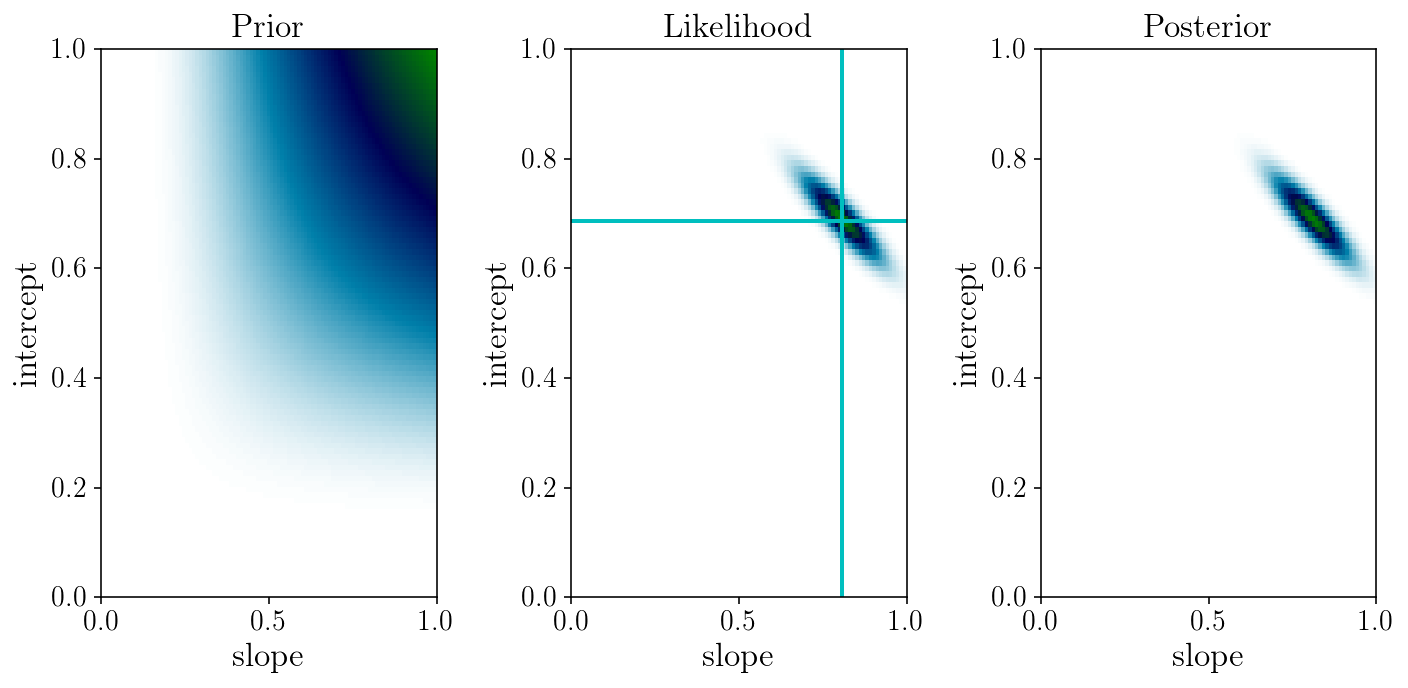

In [22]:
fig, axs = plt.subplots(1, 3)
for i in range(3):
    axs[i].set_ylabel('intercept'); axs[i].set_xlabel('slope'); 
axs[0].set_title('Prior'); axs[1].set_title('Likelihood'); axs[2].set_title('Posterior')
axs[1].axvline(slope_ml, c=colors[1]); axs[1].axhline(intercept_ml, c=colors[1])
axs[0].pcolormesh(slope_grid, intercept_grid, prior_grid, cmap='ocean_r')
axs[1].pcolormesh(slope_grid, intercept_grid, likelihood_grid, cmap='ocean_r')
axs[2].pcolormesh(slope_grid, intercept_grid, posterior_grid, cmap='ocean_r')
fig.tight_layout()

Discussion: what priors are adequate here? 

Three common types of priors are:
- Empirical priors
- Conjugate priors
- Flat priors
- Non-informative priors

## The Curse of Dimensionality (v1)

Problems with 'gridding': number of likelihood evaluations, resolution of the grids, etc

Number of point/evaluations of the likelihood: 10000


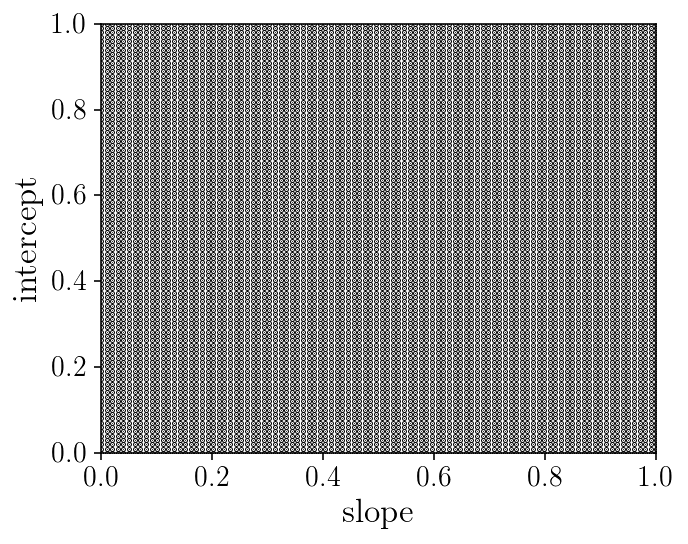

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel('slope'); ax.set_ylabel('intercept');
ax.scatter(slope_grid.ravel(), intercept_grid.ravel(), marker='.', s=1)
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
fig.tight_layout()
print('Number of point/evaluations of the likelihood:', slope_grid.size)

In [ ]:
Note to Boris: Go back to slides!

## Sampling posterior distributions with MCMC

We are going to approximate the posterior distribution with a set of samples (see slides).

EXERCISE

Write three functions returning:
        
- the log of the likelihood `ln_like(params, args...)`.

- the log of the prior `ln_prior(params, args...)`.

- the log of the posterior `ln_post(params, args...)`.


The likelihood is pretty much our previous loss function.

The prior should return `-np.inf` outside of our parameter space of interest. At this stage use a uniform prior in $[0, 1] \times [0, 1]$. 

Think about what other priors could be used. Include the correct normalization in the prior and the likelihood if possible. 

In [24]:
def ln_like(params, xs, observed_yis, yi_uncertainties):
    model_yis = model_linear(xs, params[0], params[1])
    chi2s = ((observed_yis - model_yis) / yi_uncertainties)**2
    return np.sum(-0.5 * chi2s - 0.5*np.log(2*np.pi) - np.log(yi_uncertainties))

def ln_prior(params):
    if np.any(params < 0) or np.any(params > 1):
        return - np.inf
    return 0.

def ln_post(params, xs, observed_yis, yi_uncertainties):
    lnprior_val = ln_prior(params)
    if ~np.isfinite(lnprior_val):
        return lnprior_val
    else:           
        lnlike_val = ln_like(params, xs, observed_yis, yi_uncertainties)
        return lnprior_val + lnlike_val

In [25]:
x0 = np.array([0.5, 0.5])
print('Likelihood:', ln_like(x0, xis_true, yis_noisy, sigma_yis))
print('Prior:', ln_prior(x0))
print('Posterior:', ln_post(x0, xis_true, yis_noisy, sigma_yis))

Likelihood: -130.332246225
Prior: 0.0
Posterior: -130.332246225


EXERCISE (2 min)

Find the maximum of the log posterior. Try different optimizers in `scipy.optimize.minimize`. Be careful about the sign of the objective function (is it plus or minus the log posterior?)

In [26]:
# SOLUTION
def fun(p0):
    return - ln_post(p0, xis_true, yis_noisy, sigma_yis)

res = scipy.optimize.minimize(fun, np.random.uniform(0, 1, 2), method='Powell')
print(res)
best_parmas = res.x

   direc: array([[ 0.        ,  1.        ],
       [-0.02105836,  0.01240077]])
     fun: -14.363057853259749
 message: 'Optimization terminated successfully.'
    nfev: 108
     nit: 3
  status: 0
 success: True
       x: array([ 0.80354061,  0.68722564])


/Users/bl/anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


## Sampling strategy 1: Rejection Sampling

EXERCISE

Implement rejection sampling. Randomly draw points in our 2D parameter space. Keep each point with a probability proportional to the posterior distribution.

HINT: you will find that you need to normalize the posterior distribution in some way to make the sampling possible. Use the MAP solution we just found!

In [27]:
# SOLUTION
normalization = ln_post(best_parmas, xis_true, yis_noisy, sigma_yis)
print(normalization)
num_draws = 10000
i_draw = 0
params_drawn = np.zeros((num_draws, 2))
params_vals = np.zeros((num_draws, ))
num_tot = 0
while i_draw < num_draws:
    params_drawn[i_draw, :] = np.random.uniform(0, 1, 2)
    params_vals[i_draw] = np.exp(
        ln_post(params_drawn[i_draw, :], xis_true, yis_noisy, sigma_yis)\
        - normalization)
    num_tot += 1
    if np.random.uniform(0, 1, 1) < params_vals[i_draw]:
        #print(params_vals[i_draw], i_draw)
        i_draw += 1
print(num_tot, num_draws)

14.3630578533
981523 10000


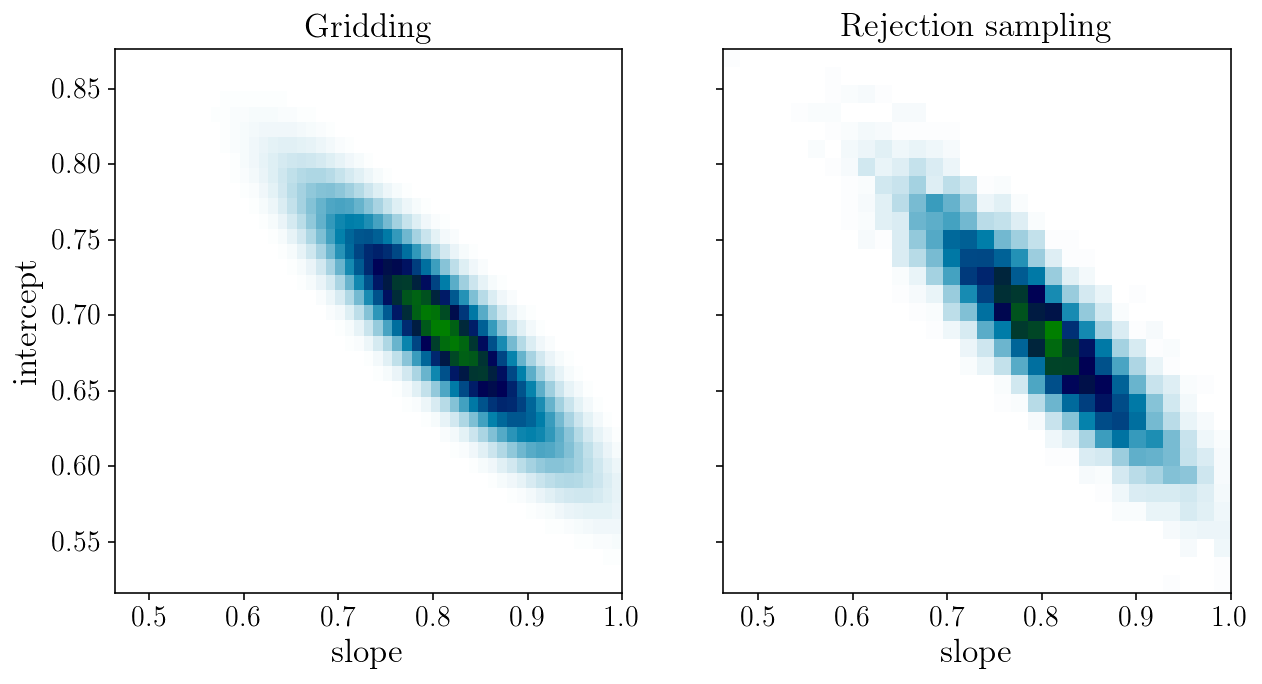

In [28]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].pcolormesh(slope_grid, intercept_grid, likelihood_grid, cmap='ocean_r')
axs[1].hist2d(params_drawn[:, 0], params_drawn[:, 1], 30, cmap="ocean_r");
axs[0].set_title('Gridding'); axs[1].set_title('Rejection sampling'); 
axs[0].set_xlabel('slope'); axs[0].set_ylabel('intercept'); axs[1].set_xlabel('slope'); 

## Sampling strategy 2: Metropolis-Hastings

The Metropolis-Hastings algorithm

For a given target probability $p(\theta)$ and a (symmetric) proposal density $p(\theta_{i+1}|\theta_i)$. We repeat the following: 
- draw a sample $\theta_{i+1}$ given $\theta_i$ from the proposal density, 
- compute the acceptance probability ratio $a={p(\theta_{i+1})}/{p(\theta_i)}$, 
- draw a random uniform number $r$ in $[0, 1]$ and accept $\theta_{i+1}$ if $r < a$.

EXERCISE

Use your implementation of the Metropolis-Hastings algorithm to draw samples from our 2D posterior distribution of interest.

Measure the proportion of parameter draws that are accepted: the acceptance rate.

Plot the chain and visualize the burn-in phase.

Compare the sampling to our previous gridded version.

Estimate the mean and standard deviation of the distribution from the samples. Are they accurate? 

In [29]:
# SOLUTION
num_draws = 1000
params_drawn = np.zeros((num_draws, 2))
i_draw = 1
num_draws_tot = 0
params_drawn[0, :] = np.random.uniform(0, 1, 2)
while i_draw < num_draws:
    num_draws_tot += 1
    params_drawn[i_draw, :] = params_drawn[i_draw-1, :] \
        + 0.05 * np.random.randn(2)
    a = np.exp(ln_post(params_drawn[i_draw, :], xis_true, yis_noisy, sigma_yis)\
                   - ln_post(params_drawn[i_draw-1, :], xis_true, yis_noisy, sigma_yis))
    if a >= 1 or np.random.uniform(0, 1, 1) < a:
        i_draw += 1
print('Acceptance rate:', num_draws/num_draws_tot)

Acceptance rate: 0.3775009437523594


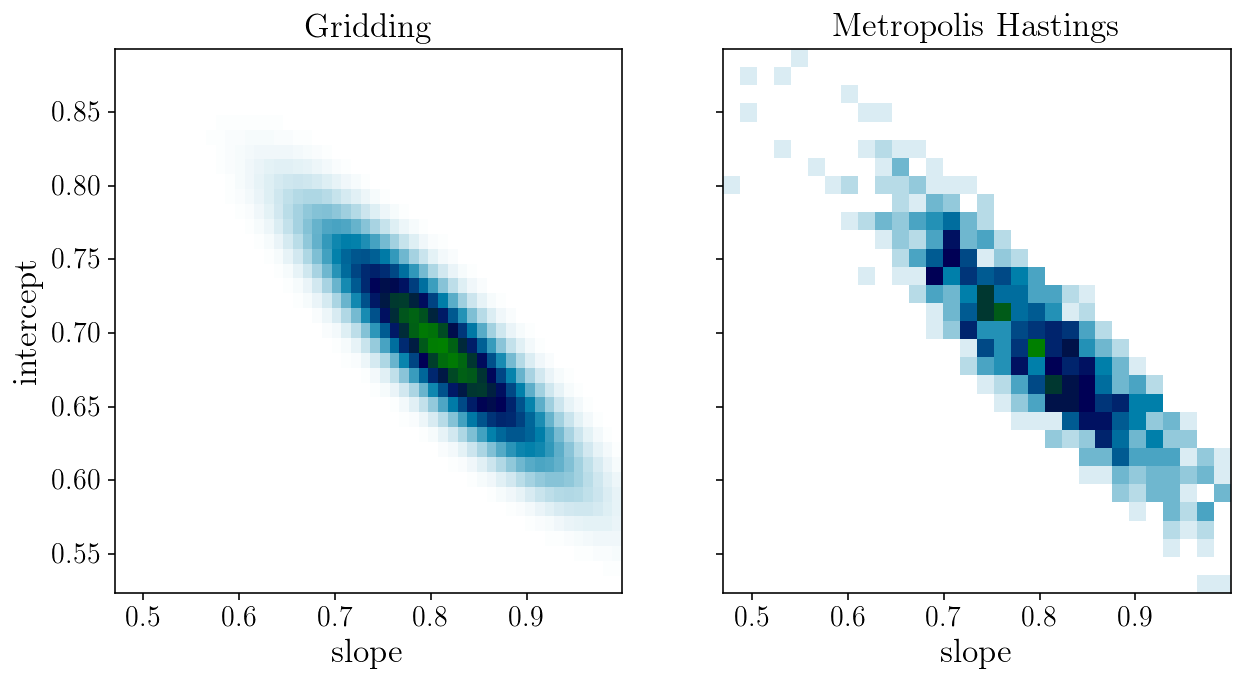

In [30]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].pcolormesh(slope_grid, intercept_grid, likelihood_grid, cmap='ocean_r')
axs[1].hist2d(params_drawn[:, 0], params_drawn[:, 1], 30, cmap="ocean_r");
axs[0].set_title('Gridding'); axs[1].set_title('Metropolis Hastings'); 
axs[0].set_xlabel('slope'); axs[0].set_ylabel('intercept'); axs[1].set_xlabel('slope'); 

Let's visualize the chains:

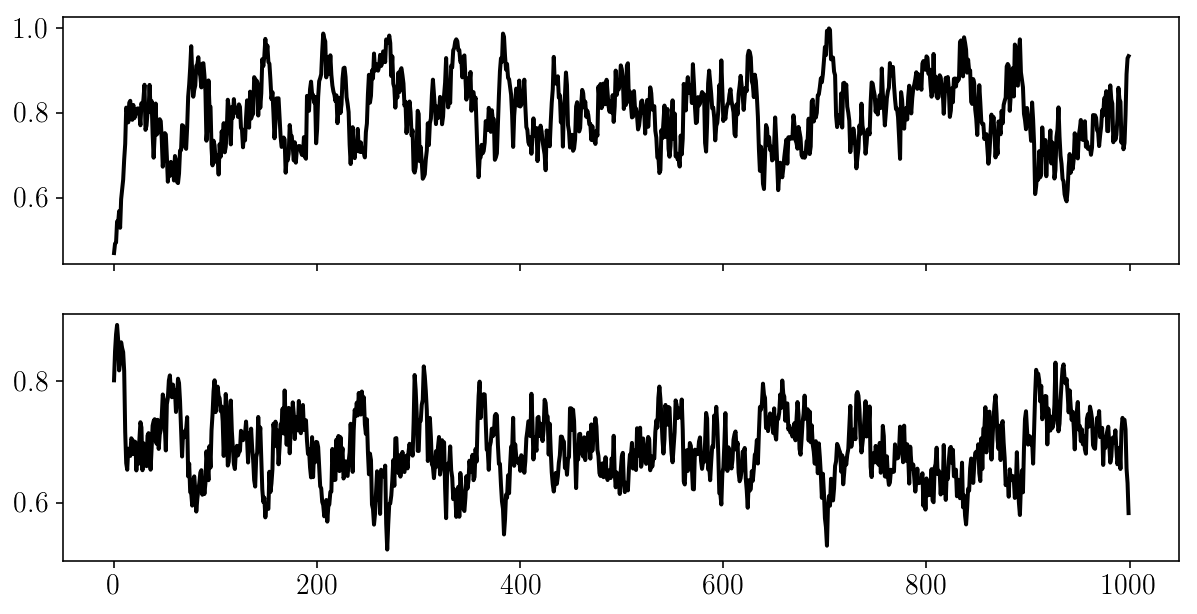

In [31]:
fig, ax = plt.subplots(2, sharex=True)
for i in range(2):
    ax[i].plot(params_drawn[:, i]);

## Validation

MCMC is approximate and is only valid if it has converged. But we can't prove that a chain has converget - we can only show it hasn't.

What to do? ___Be paranoïd.__

Is it crucial to 1) run many chains in various setups, and 2) check that the results are stable, and 3) look at the auto-correlation time:

$$\rho_k = \frac{\mathrm{Covar}[X_t, X_{t+k}]}{\mathrm{Var}[X_t]\mathrm{Var}[X_{t+k}]]}$$

See http://rstudio-pubs-static.s3.amazonaws.com/258436_5c7f6f9a84bd47aeaa33ee763e57a531.html and  www.astrostatistics.psu.edu/RLectures/diagnosticsMCMC.pdf 

EXERCISE

Visualize chains, autocorrelation time, etc, for short and long chains with different proposal distributions in the Metropolis Hastings algorithm.

In [32]:
# SOLUTION
def autocorr_naive(chain, cutoff):
    auto_corr = np.zeros(cutoff-1)
    mu = np.mean(chain, axis=0)
    var = np.var(chain, axis=0)
    for s in range(1, cutoff-1):
        auto_corr[s] = np.mean( (chain[:-s] - mu) * (chain[s:] - mu) ) / var
    return auto_corr[1:]

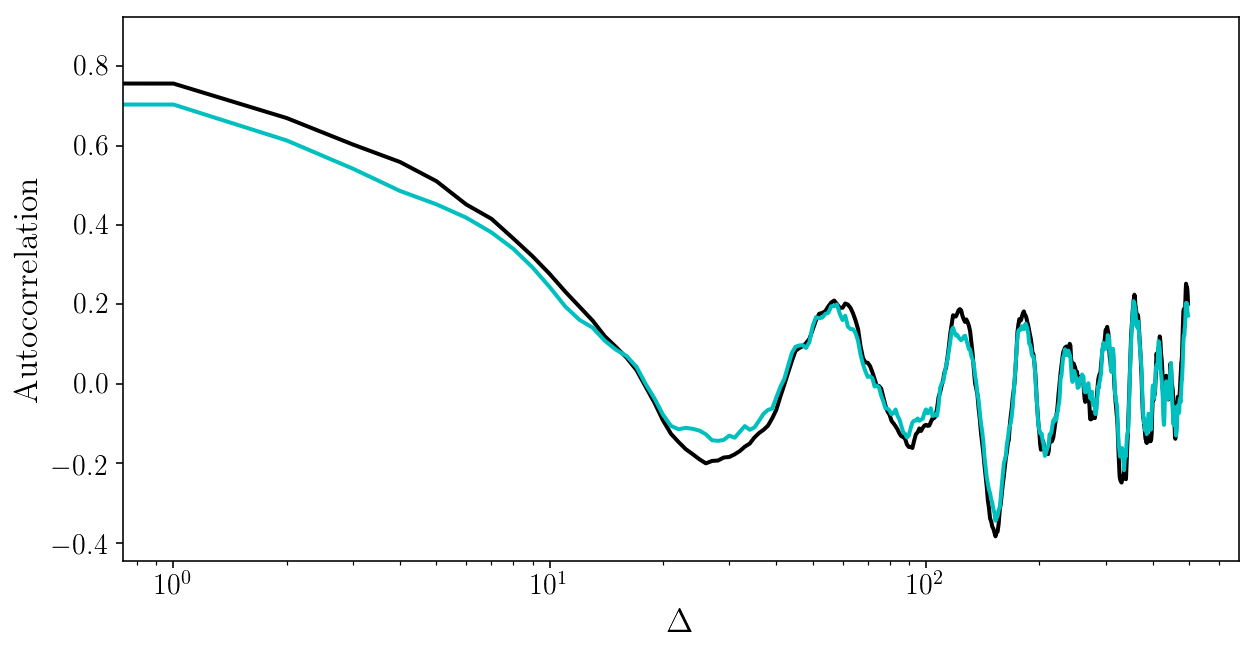

In [33]:
for i in range(2):
    plt.plot(autocorr_naive(params_drawn[:, i], 500))
plt.xscale('log'); plt.xlabel('$\Delta$'); plt.ylabel('Autocorrelation'); 

## Sampling strategy 3: affine-invariant ensemble sampler

EXERCISE

Let's use a more advanced sampler. Look at the documentation of the `emcee` package and use it to (again) draw samples from our 2D posterior distribution of interest. Make 2D plots with both `plt.hist2d` or `plt.contourf`. For the latter, add 68% and 95% confidence contours.

In [34]:
# SOLUTION
import emcee

ndim = 2
nwalkers = 50

starting_params = np.random.uniform(0, 1, ndim*nwalkers).reshape((nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post,
                                args=[xis_true, yis_noisy, sigma_yis])

num_steps = 100
pos, prob, state = sampler.run_mcmc(starting_params, num_steps)

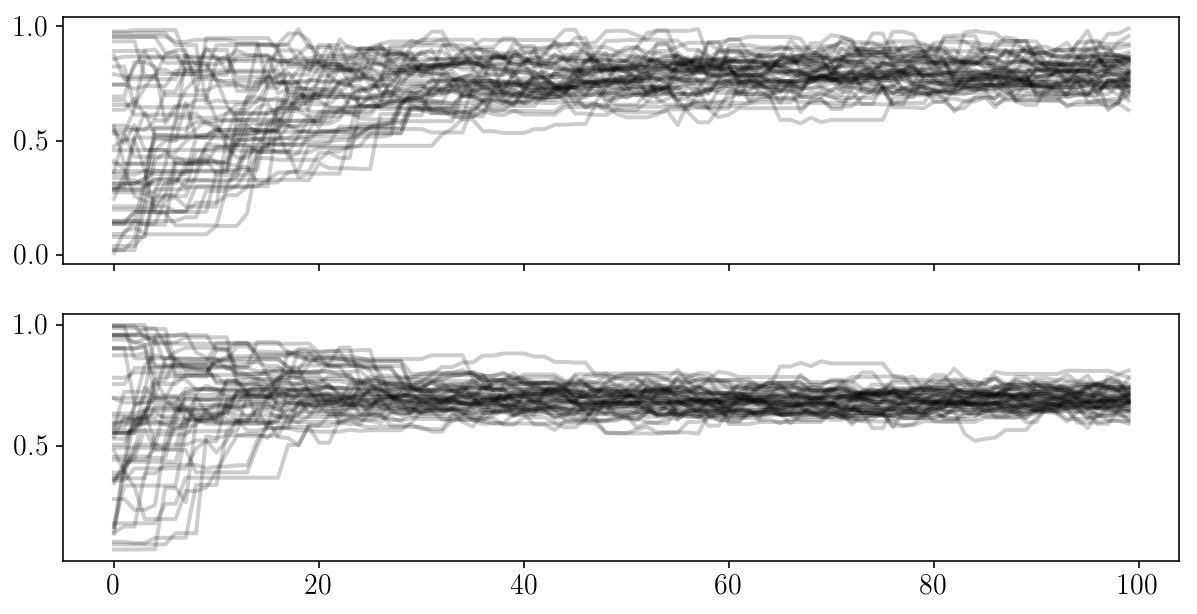

In [35]:
fig, ax = plt.subplots(2, sharex=True)
for i in range(2):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

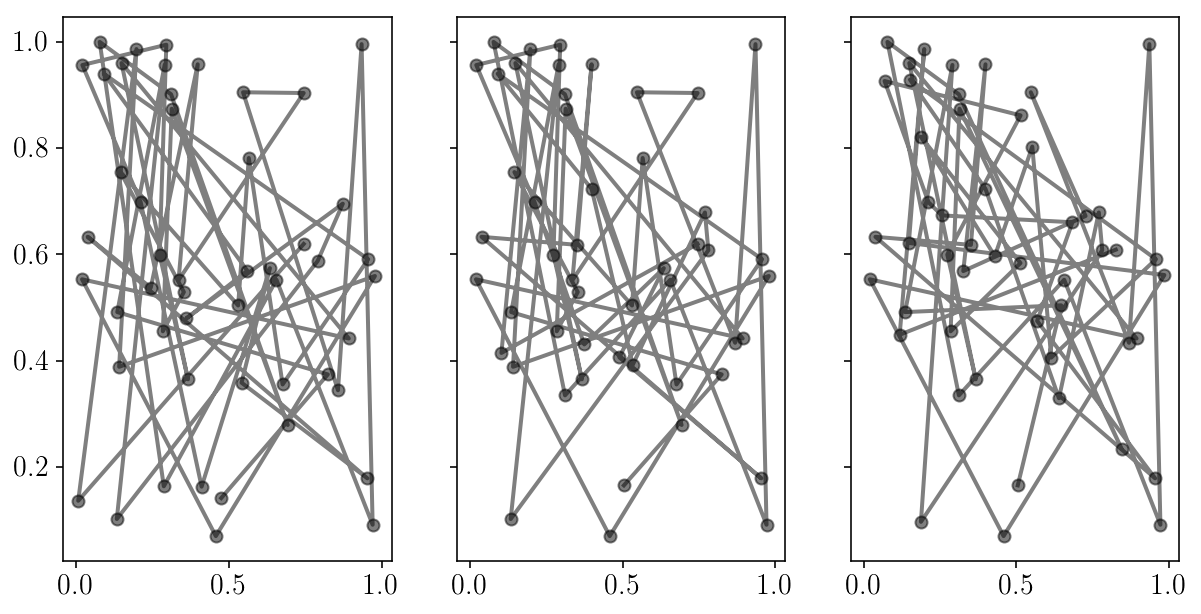

In [36]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
for i in range(axs.size):
    axs[i].errorbar(sampler.chain[:, i, 0], sampler.chain[:, i, 1], fmt="-o", alpha=0.5, c='k');

In [37]:
num_steps = 1000
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, num_steps)

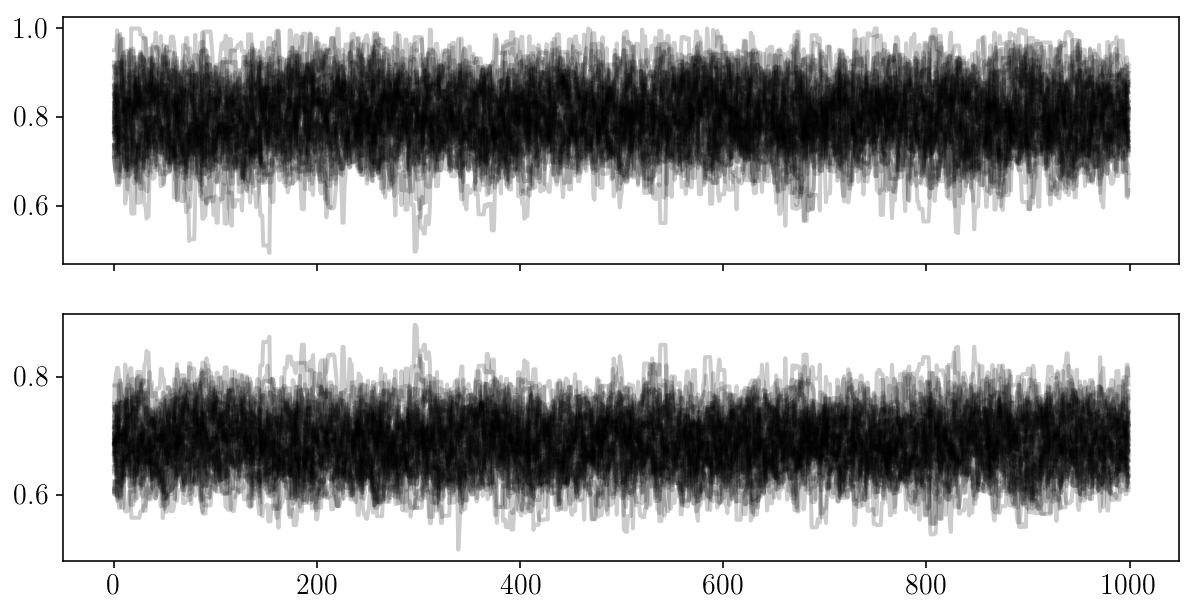

In [38]:
fig, ax = plt.subplots(2, sharex=True)
for i in range(2):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

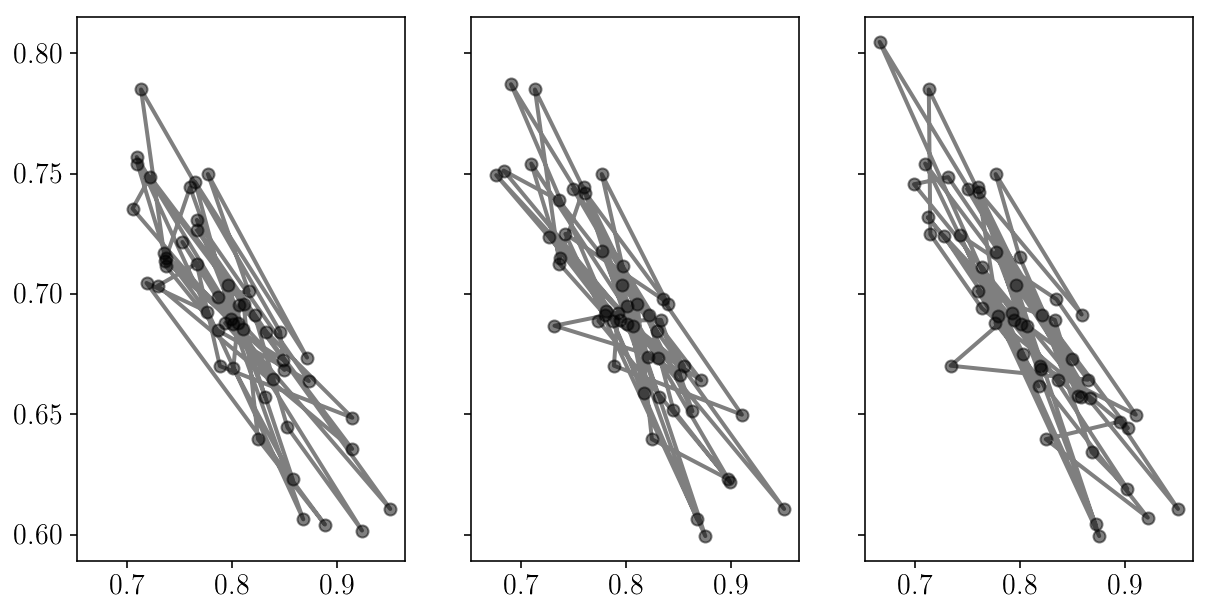

In [39]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
for i in range(axs.size):
    axs[i].errorbar(sampler.chain[:, i, 0], sampler.chain[:, i, 1], fmt="-o", alpha=0.5, c='k');

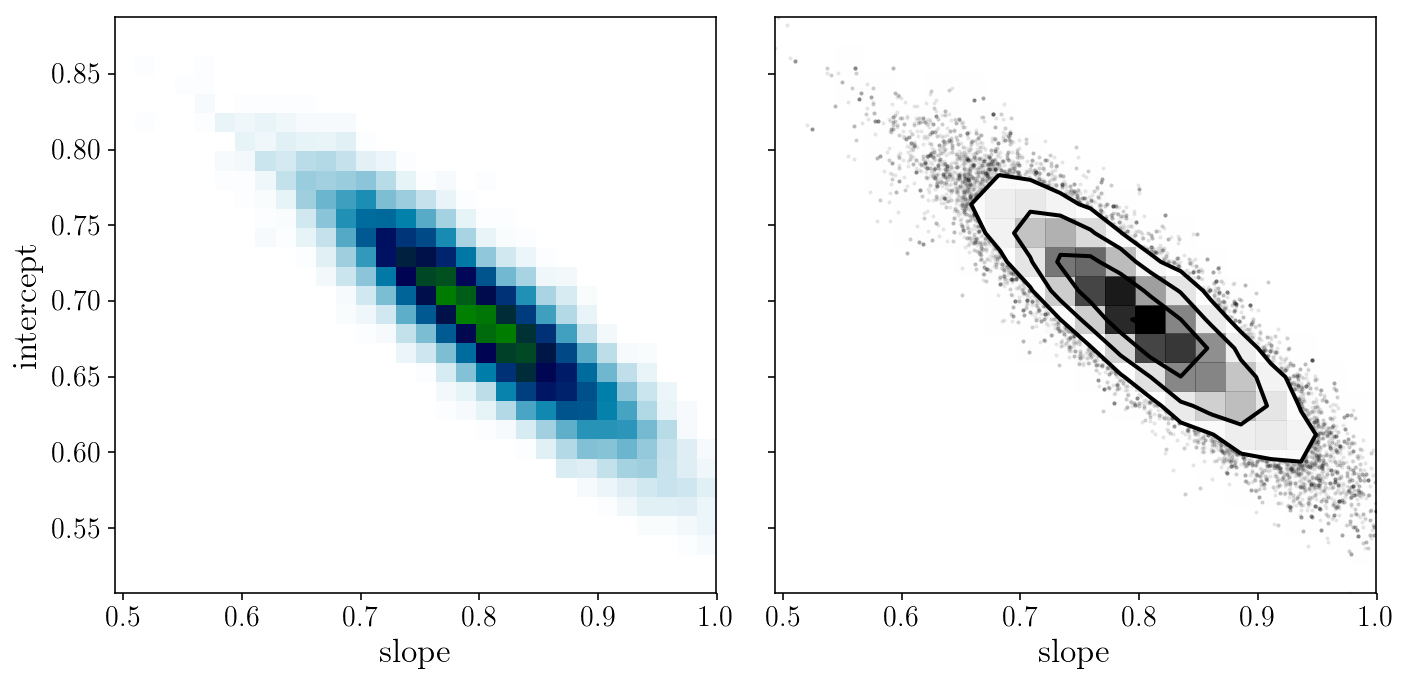

In [40]:
from corner import hist2d
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].hist2d(sampler.flatchain[:, 0], sampler.flatchain[:, 1], 30, cmap="ocean_r");
hist2d(sampler.flatchain[:, 0], sampler.flatchain[:, 1], ax=axs[1])
axs[0].set_xlabel('slope'); axs[0].set_ylabel('intercept'); axs[1].set_xlabel('slope');
fig.tight_layout()

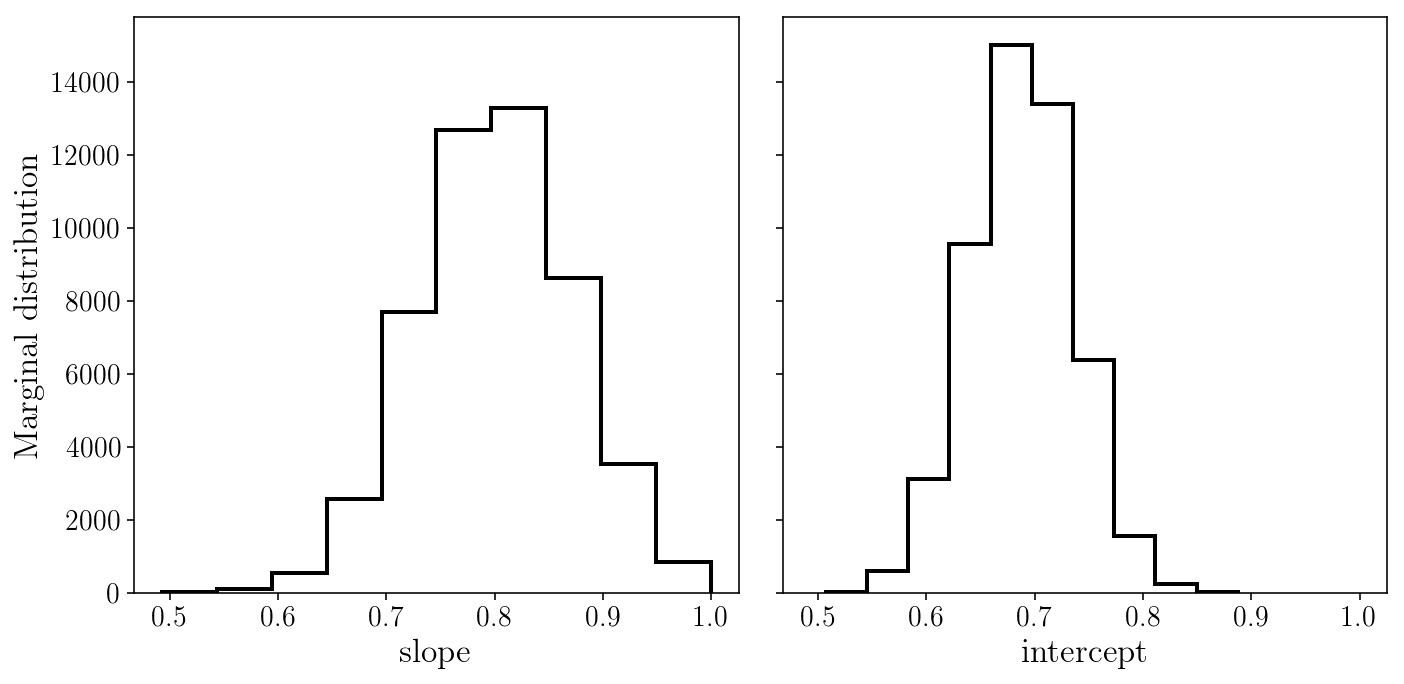

In [41]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].hist(sampler.flatchain[:, 0], histtype='step');
axs[1].hist(sampler.flatchain[:, 1], histtype='step');
axs[0].set_xlabel('slope'); axs[1].set_xlabel('intercept'); axs[0].set_ylabel('Marginal distribution'); 
fig.tight_layout()

It is extremely useful to plot the model in data space!

EXERCISE

Loop through the posterior samples (a random subset of them?) and over-plot them with the data, with some transparency.

<Container object of 3 artists>

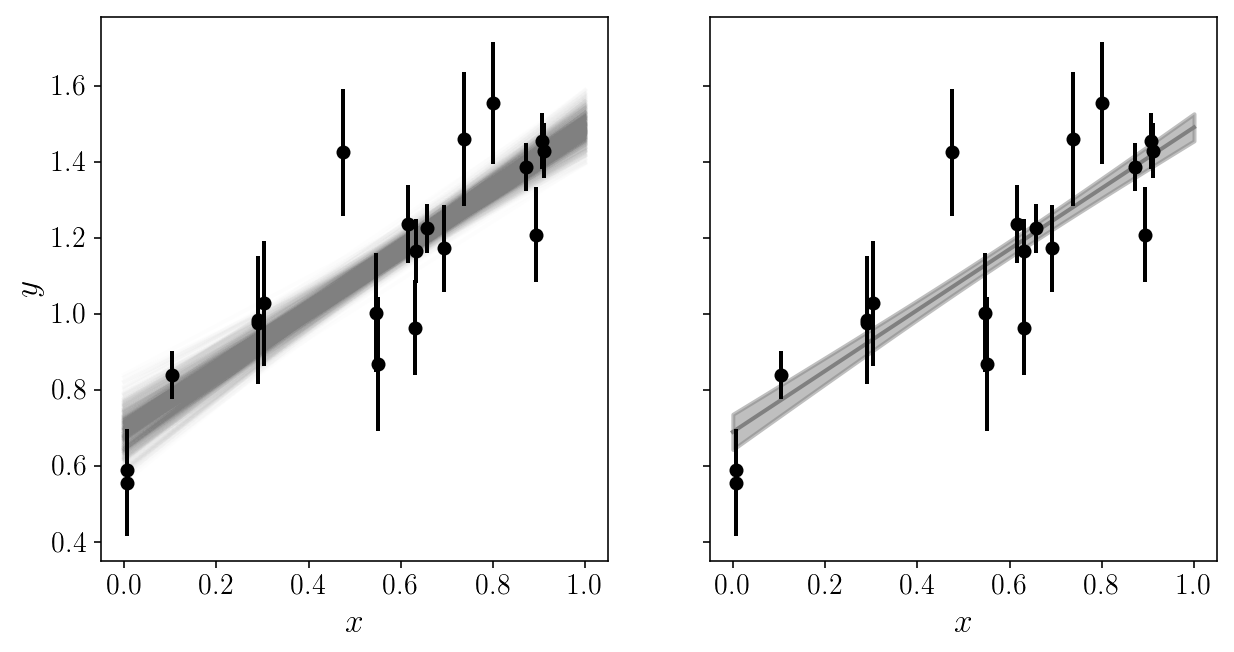

In [42]:
# SOLUTION
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].set_xlabel('$x$'); axs[1].set_xlabel('$x$'); axs[0].set_ylabel('$y$');
num = 1000
y_models = np.zeros((x_grid.size, num))
for j, i in enumerate(np.random.choice(np.arange(sampler.flatchain.shape[0]), num, replace=False)):
    y_models[:, j] = model_linear(x_grid, sampler.flatchain[i, 0], sampler.flatchain[i, 1])
    axs[0].plot(x_grid, y_models[:, j], c='gray', alpha=0.01, zorder=0)
axs[1].plot(x_grid, np.mean(y_models, axis=1), c='gray', alpha=1, zorder=0)
axs[1].fill_between(x_grid, np.mean(y_models, axis=1)-np.std(y_models, axis=1), 
            np.mean(y_models, axis=1)+np.std(y_models, axis=1), color='gray', alpha=0.5, zorder=0)
axs[0].errorbar(xis_true, yis_noisy, sigma_yis, fmt='o', zorder=1)
axs[1].errorbar(xis_true, yis_noisy, sigma_yis, fmt='o', zorder=1)

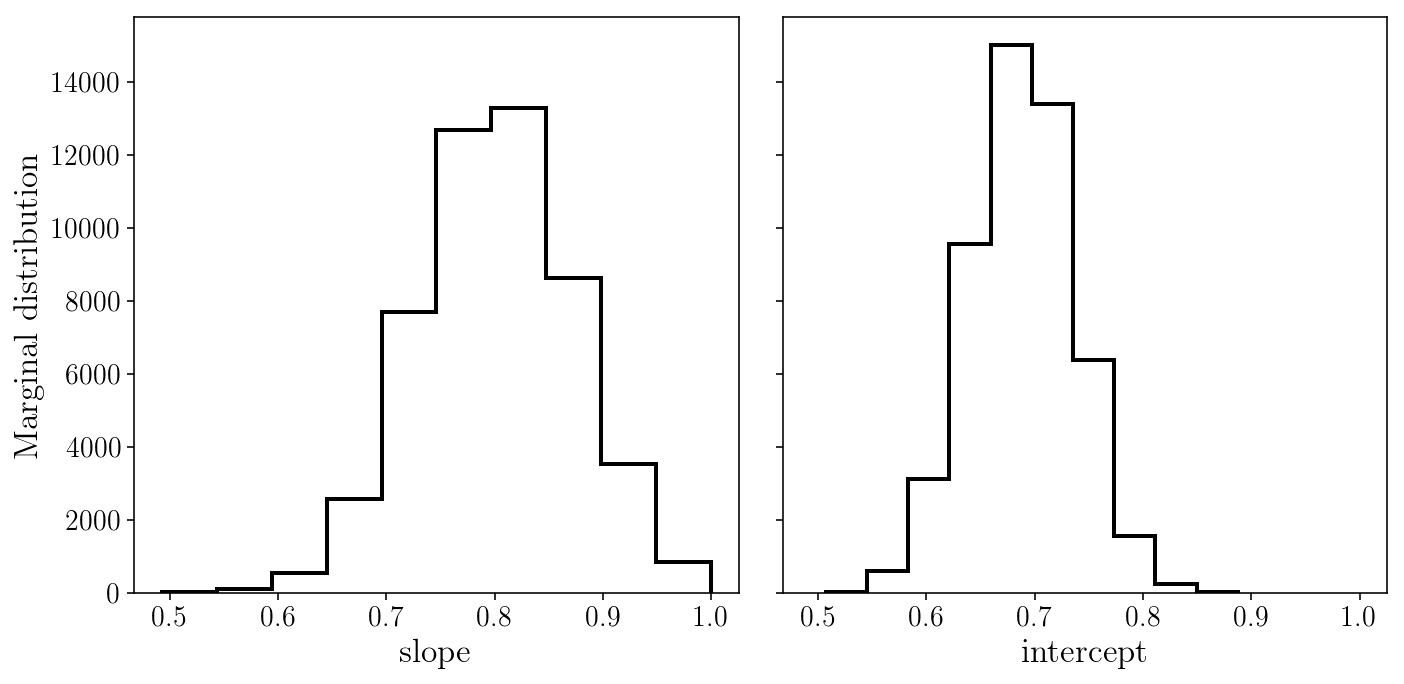

In [43]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].hist(sampler.flatchain[:, 0], histtype='step');
axs[1].hist(sampler.flatchain[:, 1], histtype='step');
axs[0].set_xlabel('slope'); axs[1].set_xlabel('intercept'); axs[0].set_ylabel('Marginal distribution'); 
fig.tight_layout()

## Parameter estimation

Often, we want to report summary statistics on our parameters, e.g. in a paper.

EXERCISE

Compute some useful summary statistics for our two parameters from the MCMC chains: mean, confidence intervals, etc

In [44]:
# SOLUTION
thechain = sampler.flatchain
print('Mean values:', np.mean(thechain, axis=0))
print('Standard deviation:', np.std(thechain, axis=0))
print('Quantiles:', np.percentile(thechain, [5, 16, 50, 84, 95], axis=0))

Mean values: [ 0.80165533  0.68901591]
Standard deviation: [ 0.0709748   0.04719852]
Quantiles: [[ 0.68605659  0.61181908]
 [ 0.7310146   0.6416856 ]
 [ 0.80158973  0.68922433]
 [ 0.87301311  0.73602509]
 [ 0.91931726  0.76652568]]


NOTE: for any subsequent analysis, don't use the summary statistics, use the full MCMC chains if you can!

CONTROVERSIAL: if you are only ever going to report and use the mean of a parameter, maybe you don't need MCMC... 

# Gibbs sampling

Because of the factorization $p(m, b) \ p(m | b)p(b) = p(b|m) p(m)$ we can actually design an algorithm to create an MCMC chain where there is __no need to reject points__! 

The procedure is simple: __given__ $(m_i, b_i)$, __draw__ $m_{i+1}$ from $p(m | b=b_i)$, then __draw__ $b_{i+1}$ from $p(b | m=m_{i+1})$.

The only __strong condition__ is to be able to draw directly from the conditional distributions, here $p(m | b)$ and $p(b|m)$.

Generalized to 3+ variables and blocks: draw from (block) conditional distributions in a sequence.

I will draw the way Gibbs sampling works on the board.

What conditional distributions do we need here? Recall that our full posterior distribution is

$$p\bigl(m, b \ \bigl\vert \ \{ \hat{y}_i, \sigma_i, x_i\} \bigr) \ \propto \ p\bigl(\{ \hat{y}_i \} \ \bigl\vert \ m, b, \{\sigma_i, x_i\}\bigr) \  p\bigl(m, b\bigr) \ = \ \exp\left( - \sum_{i=1}^{N} \frac{1}{2} \frac{(\hat{y}_i - m x_i - b)^2}{\sigma^2_i} \right) \ p\bigl(m, b\bigr) $$

If we take uniform priors, $p\bigl(m, b\bigr) = C$, then this posterior distribution is Gaussian:

$$p\bigl(m, b \ \bigl\vert \ \{ \hat{y}_i, \sigma_i, x_i\} \bigr) \ \propto \ \mathcal{N}\left( [X^TX]^{-1}X^T Y ; [X^TX]^{-1} \Sigma \right) = \mathcal{N}\left( 
\left[\begin{matrix} \hat{m} \\ \hat{b} \end{matrix}\right];
\left[\begin{matrix} \Sigma_{mm} & \Sigma_{mb}\\ \Sigma_{mb} & \Sigma_{bb} \end{matrix}\right]
\right) $$

where I have put the $x_i$'s in a $N x 2$ vector $X$ (the first column is ones, and the second contains the $x_i$'s),  the $\hat{y}_i$'s in a vector $Y$, and the $\sigma_i$'s in a diagonal matrix $\Sigma$. This matches the classic maximum likelihood results for linear regression. The variables $(\hat{m}, \hat{b}, \Sigma_{mm}, \Sigma_{mb}, \Sigma_{mb}, \Sigma_{bb})$ are a convenient notation.

By using Gaussian identities (which can for example be found [here](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)), we can write the conditional distributions 

$$p\bigl(m \ \bigl\vert \ b, \{ \hat{y}_i, \sigma_i, x_i\} \bigr) \ \propto \mathcal{N}\left( 
\hat{m} + \Sigma_{mb}\Sigma_{bb}^{-1}(b - \hat{b});
\Sigma_{mm} - \Sigma_{mb}\Sigma_{bb}^{-1}\Sigma_{mb}
\right) $$

$$p\bigl(b \ \bigl\vert \ m, \{ \hat{y}_i, \sigma_i, x_i\} \bigr) \ \propto \mathcal{N}\left( 
\hat{b} + \Sigma_{mb}\Sigma_{mm}^{-1}(m - \hat{m});
\Sigma_{bb} - \Sigma_{mb}\Sigma_{mm}^{-1}\Sigma_{mb}
\right) $$

(I lied to you ; there is an analytic solution for this problem!)

BONUS question: look up online what "conjugate priors" are appropriate for linear regression models.

In [45]:
X = np.vstack((xis_true, np.repeat(1, xis_true.size))).T
datacov = np.diag(sigma_yis**2.0)
A = np.dot(X.T, np.linalg.solve(datacov, X))
posterior_mean = np.linalg.solve(A, np.dot(X.T, np.linalg.solve(datacov, yis_noisy[:, None]))).ravel()
print('Posterior mean:', posterior_mean)
posterior_covariance = np.linalg.inv(np.dot(X.T,  np.linalg.solve(datacov, X)))
print('Posterior covariance:', posterior_covariance)

Posterior mean: [ 0.80354061  0.68722564]
Posterior covariance: [[ 0.00512151 -0.00301594]
 [-0.00301594  0.00226952]]


Important note: you might think sampling is useless here because we know the analytic posterior distribution...
    
But there is a very wide class of problems and models where you cannot find an analytic solution for the full posterior distribution, but __you can write the conditional posterior distributions on the parameters__! 

In fact, in hierarchical models, in 99% of cases, we automatically have the conditional distributions, but it is how we construct the model. For this reason, and because Gibbs sampling has an acceptance rate of 1, it is very powerful and popular, and often a default solution!

EXERCISE: using those results, implement Gibbs sampling!

In [46]:
# SOLUTION
num_draws = 10000
i_draw = 0
params_drawn = np.zeros((num_draws, 2))
params_drawn[0, :] = posterior_mean + 0.01*np.random.uniform(0, 1, 2)
for i_draw in range(1, num_draws):
    mu = posterior_mean[0] + posterior_covariance[1, 0] *\
        (params_drawn[i_draw-1, 1] - posterior_mean[1]) / posterior_covariance[1, 1]
    cov = posterior_covariance[0, 0] - posterior_covariance[1, 0]**2 / posterior_covariance[1, 1]
    params_drawn[i_draw, 0] = mu + np.random.randn() * cov**0.5
    
    mu = posterior_mean[1] + posterior_covariance[1, 0] *\
        (params_drawn[i_draw, 0] - posterior_mean[0]) / posterior_covariance[0, 0]
    cov = posterior_covariance[1, 1] - posterior_covariance[1, 0]**2 / posterior_covariance[0, 0]
    params_drawn[i_draw, 1] = mu + np.random.randn() * cov**0.5

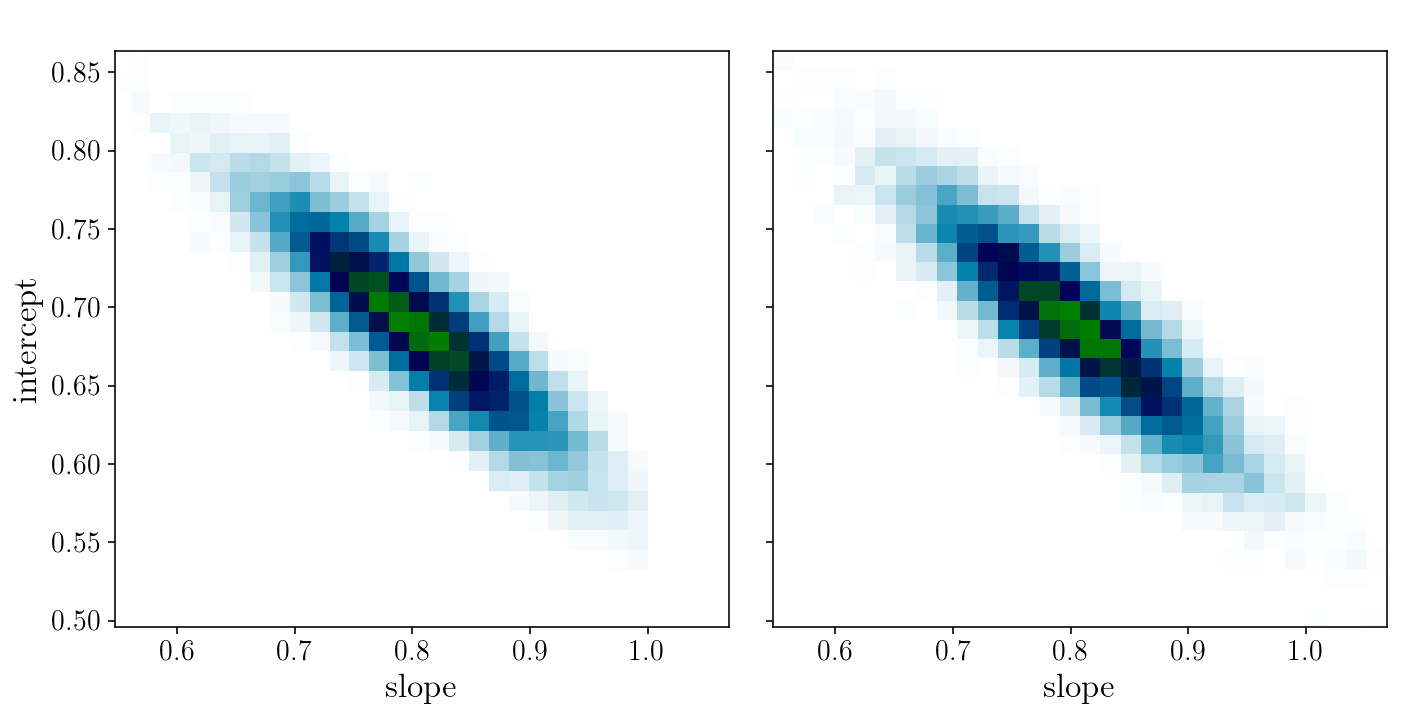

In [47]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].hist2d(sampler.flatchain[:, 0], sampler.flatchain[:, 1], 30, cmap="ocean_r");
axs[1].hist2d(params_drawn[:, 0], params_drawn[:, 1], 30, cmap="ocean_r");
axs[0].set_xlabel('slope'); axs[0].set_ylabel('intercept'); axs[1].set_xlabel('slope');
fig.tight_layout()

### Final words on Gibbs sampling
It is great to have an acceptance rate of 1, but we critically need nice conditional distributions, and no nasty degeneracies between the parameters. 

In [ ]:
Note to Boris: Go back to slides!

## Fitting data with both x and y errors

We observe a set of $\hat{x}_i$ which are noisified versions of the true $x_i$, with Gaussian noise $\gamma_i$. 

In [48]:
sigma_xis = np.repeat(0.1, ndatapoints) * np.random.uniform(0.2, 1.0, ndatapoints)
xis_noisy = xis_true + sigma_xis * np.random.randn(xis_true.size)

(0.41604768379354951, 1.7139330794192902)

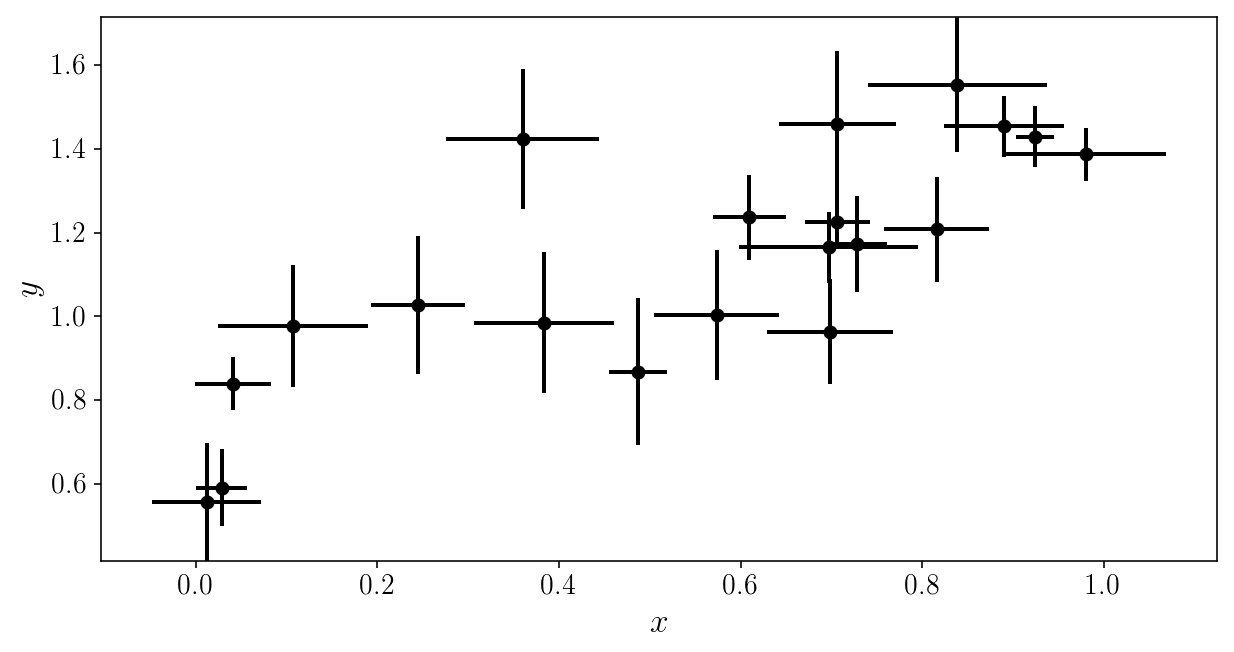

In [49]:
plt.errorbar(xis_noisy, yis_noisy, xerr=sigma_xis, yerr=sigma_yis, fmt='o')
plt.xlabel('$x$'); plt.ylabel('$y$'); plt.ylim([y_min, y_max])

Our likelihood is now:

$$\begin{align}
p(D| P, M) &= p(\{ \hat{y}_i, \hat{x}_i \} \vert \{\sigma_i, \gamma_i, x_i\}, \textrm{intercept}, \textrm{slope}) \\
&= \prod_{i=1}^{N} p(\hat{y}_i \vert x_i, \sigma_i, b, m) \ p(\hat{x}_i \vert x_i, \gamma_i) \\
& = \prod_{i=1}^{N} \mathcal{N}\left(\hat{y}_i - m x_i - b; \sigma^2_i \right) \mathcal{N}\left(\hat{x}_i - x_i; \gamma^2_i \right)
\end{align}
$$

We now have $N$ extra parameters, the $x_i$'s!

The full posterior distribution:

$$  p\bigl( m, s, \{  x_i \} \bigl\vert  \{ \hat{y}_i, \hat{x}_i, \sigma_i, \gamma_i\} \bigr) \ \propto  \
p\bigl(\{ \hat{y}_i, \hat{x}_i \} \bigl\vert \{\sigma_i, \gamma_i, x_i\}, m, s\bigr) \ \ p\bigl(\{ x_i \}, m, s\bigr) $$

## This is the Curse of Dimensionality v2!

## One solution : Hamiltonian Monte Carlo

Neal's book chapter is a good starting point: https://arxiv.org/abs/1206.1901 

Demo: https://chi-feng.github.io/mcmc-demo/app.html

Gradients (and hessians) needed! Three strategies:
- pen and paper, then home-made implementation
- automatic symbolic differentiation
- automatic numerical differentition
    
Always try auto-diff first (e.g., with `autograd`). 

Large-scale inference (gazilion parameters): try `tensorflow`

## Analytic marginalization of latent variables

We are only truly interested in the marginalized posterior distribution:

$$p\bigl( m, s \bigl\vert  \{ \hat{y}_i, \hat{x}_i, \sigma_i, \gamma_i\} \bigr) \ = \ \int\mathrm{d}\{x_i\} p\bigl( m, s, \{  x_i \} \bigl\vert  \{ \hat{y}_i, \hat{x}_i, \sigma_i, \gamma_i\} \bigr) \\
 \propto \  \prod_{i=1}^{N} \int \mathrm{d}x_i \mathcal{N}\left(\hat{y}_i - m x_i - b; \sigma^2_i \right) \mathcal{N}\left(\hat{x}_i - x_i; \gamma^2_i \right) \ \ p\bigl(\{ x_i \}, m, s\bigr) \\
 \propto \  \prod_{i=1}^{N} \mathcal{N}\left(\hat{y}_i - m \hat{x}_i - b; \sigma^2_i + \gamma^2_i\right)  \ p(s, m) $$

with flat uninformative priors on $x_i$'s $p\bigl(x_i)$.

We have eliminated the $x_i$'s!

In [50]:
HTML('<img src="./pics/magic.gif" width=500>')

Let us do a run with the x's fixed to their noisy values (which is wrong! This is ignoring the x noise).

In [51]:
ndim = 2
nwalkers = 50

starting_params = np.random.uniform(0, 1, ndim*nwalkers).reshape((nwalkers, ndim))
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, ln_post,
                                args=[yis_noisy, xis_noisy, sigma_yis])

num_steps = 100
pos, prob, state = sampler2.run_mcmc(starting_params, num_steps)
num_steps = 1000
sampler2.reset()
pos, prob, state = sampler2.run_mcmc(pos, num_steps)

In [52]:
def ln_like(params, observed_yis, observed_xis, yi_uncertainties, xi_uncertainties):
    xyi_uncertainties = np.sqrt(xi_uncertainties**2. + yi_uncertainties**2.)
    model_yis = model_linear(observed_xis, params[0], params[1])
    return np.sum(-0.5 * ((observed_yis - model_yis) / xyi_uncertainties)**2
                   - 0.5*np.log(2*np.pi) - np.log(xyi_uncertainties))

def ln_prior(params):
    if np.any(params < 0) or np.any(params > 1):
        return - np.inf
    return 0.

def ln_post(params, observed_yis, observed_xis, yi_uncertainties, xi_uncertainties):
    lnprior_val = ln_prior(params)
    if ~np.isfinite(lnprior_val):
        return lnprior_val
    else:           
        lnlike_val = ln_like(params, observed_yis, observed_xis, yi_uncertainties, xi_uncertainties)
        return lnprior_val + lnlike_val

In [53]:
x0 = np.repeat(0.5, 2)
print('Likelihood:', ln_like(x0, yis_noisy, xis_noisy, sigma_yis, sigma_xis))
print('Prior:', ln_prior(x0))
print('Posterior:', ln_post(x0, yis_noisy, xis_noisy, sigma_yis, sigma_xis))

Likelihood: -82.6766239366
Prior: 0.0
Posterior: -82.6766239366


In [54]:
ndim = 2
nwalkers = 50

starting_params = np.random.uniform(0, 1, ndim*nwalkers).reshape((nwalkers, ndim))
sampler3 = emcee.EnsembleSampler(nwalkers, ndim, ln_post,
                                args=[yis_noisy, xis_noisy, sigma_yis, sigma_xis])

num_steps = 100
pos, prob, state = sampler3.run_mcmc(starting_params, num_steps)
num_steps = 1000
sampler3.reset()
pos, prob, state = sampler3.run_mcmc(pos, num_steps)

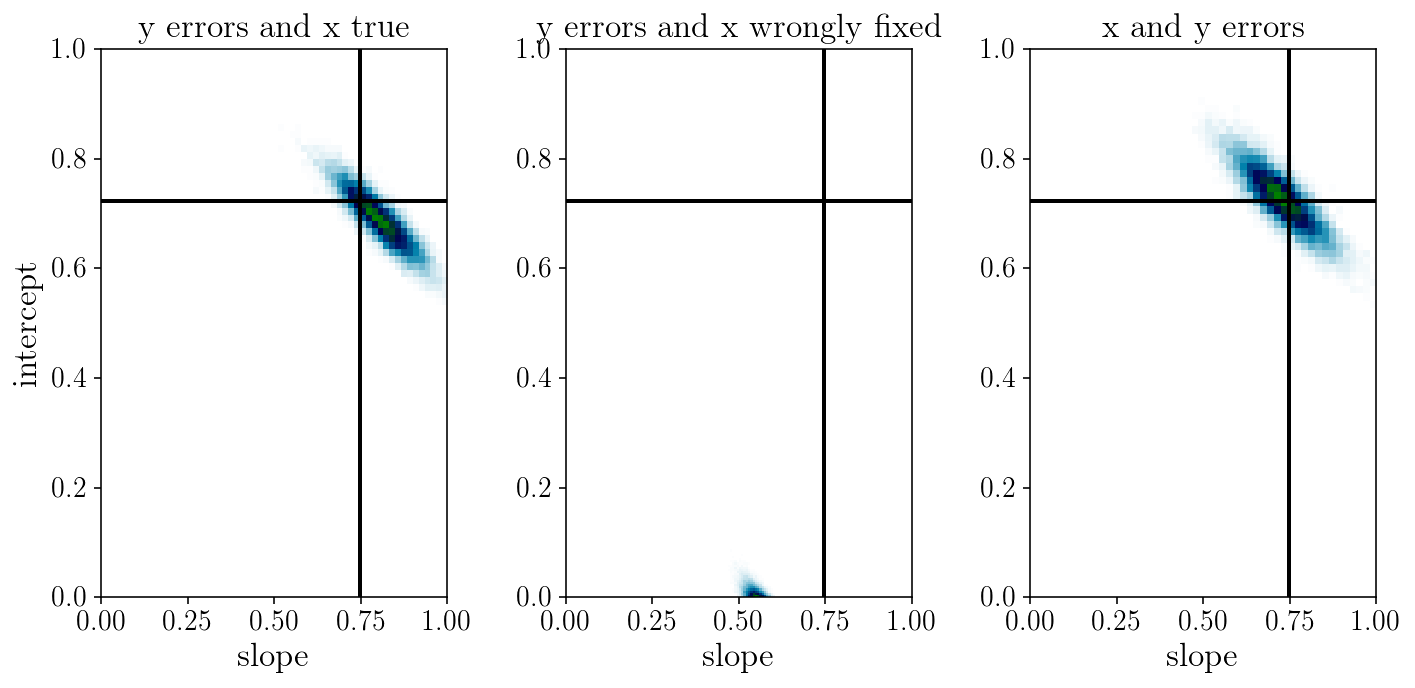

In [67]:
fig, axs = plt.subplots(1, 3, sharex=False, sharey=False)
axs[0].hist2d(sampler.flatchain[:, 0], sampler.flatchain[:, 1], 30, cmap="ocean_r");
axs[1].hist2d(sampler2.flatchain[:, 0], sampler2.flatchain[:, 1], 30, cmap="ocean_r");
axs[2].hist2d(sampler3.flatchain[:, 0], sampler3.flatchain[:, 1], 30, cmap="ocean_r");
axs[0].set_title('y errors and x true'); 
axs[1].set_title('y errors and x wrongly fixed');  
axs[2].set_title('x and y errors');
axs[0].set_xlabel('slope'); axs[0].set_ylabel('intercept'); 
axs[1].set_xlabel('slope');
axs[2].set_xlabel('slope');
for i in range(3):
    axs[i].axvline(slope_true)
    axs[i].axhline(intercept_true)
    axs[i].set_ylim([0, 1])
    axs[i].set_xlim([0, 1])
fig.tight_layout()

<Container object of 3 artists>

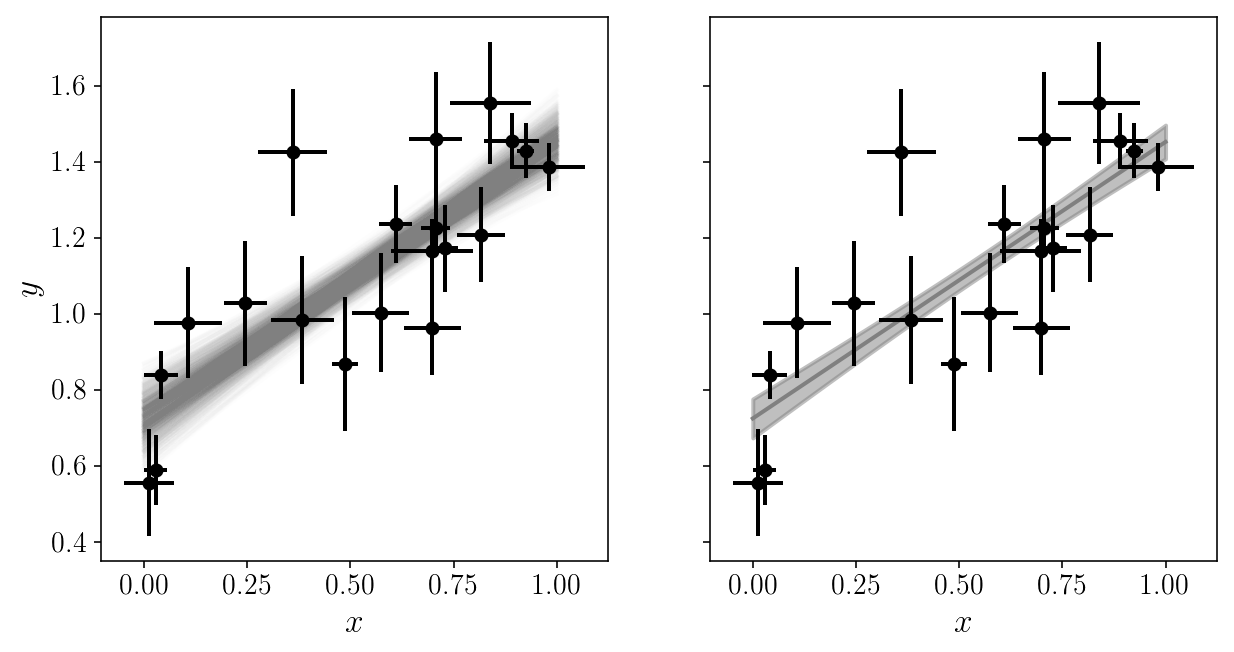

In [59]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].set_xlabel('$x$'); axs[1].set_xlabel('$x$'); axs[0].set_ylabel('$y$');
num = 1000
y_models = np.zeros((x_grid.size, num))
for j, i in enumerate(np.random.choice(np.arange(sampler3.flatchain.shape[0]), num, replace=False)):
    y_models[:, j] = model_linear(x_grid, sampler3.flatchain[i, 0], sampler3.flatchain[i, 1])
    axs[0].plot(x_grid, y_models[:, j], c='gray', alpha=0.01, zorder=0)
axs[1].plot(x_grid, np.mean(y_models, axis=1), c='gray', alpha=1, zorder=0)
axs[1].fill_between(x_grid, np.mean(y_models, axis=1)-np.std(y_models, axis=1), 
            np.mean(y_models, axis=1)+np.std(y_models, axis=1), color='gray', alpha=0.5, zorder=0)
axs[0].errorbar(xis_noisy, yis_noisy, xerr=sigma_xis, yerr=sigma_yis, fmt='o', zorder=1)
axs[1].errorbar(xis_noisy, yis_noisy, xerr=sigma_xis, yerr=sigma_yis, fmt='o', zorder=1)

We got around the number of parameters by analytically marginalizing the ones we don't really care about. Sometimes this is not possible!

# Extensions

- __Automatic differentiation__ with autograd, tensorflow, etc.
- __Nested Sampling for nasty distributions and model comparison__. Application: fitting multiple components/lines to a data set.
- __Model testing, model comparison__. I have multiple models. Which is the best? Example: fit multiple lines to data.
- __Gibbs sampling__: The default solution for population models.
- __Large hierarchical models and high-dimensional parameters inference__: Graphical representation of hierarchical models and parameter inference.
- __Hamiltonian Monte Carlo with quasi-auto-tuning for millions of parameters.__ Application: fitting a line with many latent parameters (x noise, outliers, etc).
- __Multi-stage hybrid sampling__: Application: non-linear models with many parameters and complicated gradients. 
- __Connections to deep machine learning__: Bayesian interpretation of Convolution networks, Adversarial training, deep forward models, etc. TensorFlow.

Let me know if you are interested and we will organize a session. A few notebooks and mode advanced examples available on https://ixkael.github.io

# Final thoughts
With the right method you can solve problems/models that seem intractable. Don't underestimate yourself! Start small, but be ambitious.

In [57]:
HTML('<img src="./pics/dreams.jpg" width=500>')

https://chi-feng.github.io/mcmc-demo/app.html